In [2]:
!pip install librosa
!pip install ipywidgets
!pip install resampy


In [3]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

print("Libraries imported.")

Libraries imported.


In [10]:
METADATA_DIR = 'fma_metadata/fma_metadata'
AUDIO_DIR = 'fma_small/fma_small' 
OUTPUT_SPECTROGRAMS_DIR = 'fma_spectrograms'

SAMPLE_RATE = 22050
DURATION = 10
N_MELS = 128
HOP_LENGTH = 512
N_FFT = 2048

# --- Helper Function ---
def get_audio_path(audio_dir, track_id):
    """Constructs the path to an audio file."""
    tid_str = f'{track_id:06d}'
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

# --- Main Preprocessing Logic ---
def create_spectrograms():
    print("Starting audio preprocessing...")
    
    # Load metadata
    try:
        tracks_path = os.path.join(METADATA_DIR, 'tracks.csv')
        tracks_df = pd.read_csv(tracks_path, header=[0, 1], index_col=0)
    except FileNotFoundError:
        print(f"ERROR: 'tracks.csv' not found in '{METADATA_DIR}'. Please check the path.")
        return

    # Filter for the 'small' subset
    small_subset_tracks = tracks_df[tracks_df[('set', 'subset')] == 'small']
    print(f"Found {len(small_subset_tracks)} tracks in the 'small' subset metadata.")

    # Create output directory
    os.makedirs(OUTPUT_SPECTROGRAMS_DIR, exist_ok=True)
    print(f"Spectrograms will be saved to '{OUTPUT_SPECTROGRAMS_DIR}'")

    # Loop through tracks, load audio, create spectrogram, and save
    for track_id, row in tqdm(small_subset_tracks.iterrows(), total=len(small_subset_tracks), desc="Processing tracks"):
        track_id = int(track_id)
        output_file_path = os.path.join(OUTPUT_SPECTROGRAMS_DIR, f'{track_id:06d}.npy')
        
        # Skip if already processed
        if os.path.exists(output_file_path):
            continue

        audio_path = get_audio_path(AUDIO_DIR, track_id)
        if not os.path.exists(audio_path):
            print(f"Warning: Audio file not found for track {track_id}. Skipping.")
            continue
            
        try:
            # Load audio file
            y, sr = librosa.load(audio_path, sr=SAMPLE_RATE, duration=DURATION, res_type='kaiser_fast')
            
            # Pad or truncate to ensure fixed length
            target_length = DURATION * sr
            if len(y) < target_length:
                y = np.pad(y, (0, target_length - len(y)))
            else:
                y = y[:target_length]

            # Compute Mel-spectrogram
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

            # Save the processed spectrogram
            np.save(output_file_path, log_mel_spec)

        except Exception as e:
            print(f"ERROR processing track {track_id}: {e}")
            continue

    print("\nPreprocessing finished!")
    print(f"{len(os.listdir(OUTPUT_SPECTROGRAMS_DIR))} spectrogram files created.")

# --- Execute the function ---
create_spectrograms() 

Starting audio preprocessing...
Found 8000 tracks in the 'small' subset metadata.
Spectrograms will be saved to 'fma_spectrograms'


Processing tracks:   0%|          | 0/8000 [00:00<?, ?it/s]

C:\Users\Benjo\AppData\Local\Temp\ipykernel_23100\384448212.py:53: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=SAMPLE_RATE, duration=DURATION, res_type='kaiser_fast')
C:\Users\Benjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


ERROR processing track 98565: 
ERROR processing track 98567: 
ERROR processing track 98569: 
ERROR processing track 99134: 
ERROR processing track 108925: 
ERROR processing track 133297: 

Preprocessing finished!
7994 spectrogram files created.


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score, balanced_accuracy_score

In [14]:
# --- Configuration ---
METADATA_DIR = 'fma_metadata/fma_metadata' 
SPECTROGRAMS_DIR = 'fma_spectrograms'

N_MELS = 128
N_TIME_STEPS = 431
INPUT_SHAPE = (N_MELS, N_TIME_STEPS, 1) 

# --- Main Data Loading Function ---
def load_data(metadata_path, spectrograms_dir):
    """Loads spectrograms and their corresponding genre labels."""
    try:
        tracks_path = os.path.join(metadata_path, 'tracks.csv')
        tracks_df = pd.read_csv(tracks_path, header=[0, 1], index_col=0)
    except FileNotFoundError:
        print(f"Error: Metadata file not found at {metadata_path}")
        return None, None

    # Filter for the 'small' subset and tracks that have a top-level genre
    small_subset = tracks_df[tracks_df[('set', 'subset')] == 'small']
    small_subset = small_subset[~small_subset[('track', 'genre_top')].isna()]

    spectrograms = []
    genres = []
    
    print(f"Found {len(small_subset)} tracks in metadata. Loading corresponding spectrograms...")

    for track_id in tqdm(small_subset.index, desc="Loading spectrograms"):
        spec_path = os.path.join(spectrograms_dir, f'{track_id:06d}.npy')
        if os.path.exists(spec_path):
            spec = np.load(spec_path)
            if spec.shape[1] == N_TIME_STEPS:
                spectrograms.append(spec)
                genres.append(small_subset.loc[track_id, ('track', 'genre_top')])

    X = np.array(spectrograms).reshape(-1, N_MELS, N_TIME_STEPS, 1)
    y = np.array(genres)

    return X, y

# --- Execute Data Loading ---
X, y = load_data(METADATA_DIR, SPECTROGRAMS_DIR)

if X is not None and len(X) > 0:
    print(f"\nLoaded {X.shape[0]} spectrograms successfully.")
    print(f"Shape of X (data): {X.shape}")
    print(f"Shape of y (labels): {y.shape}")

    # --- Encode Labels and Split Data ---
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    num_classes = len(label_encoder.classes_)
    target_class_names = label_encoder.classes_

    print(f"\nTarget variable 'genre' encoded.")
    print(f"Number of unique classes: {num_classes}")
    print(f"Class mapping: {dict(zip(label_encoder.classes_, range(num_classes)))}")

    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    print("\n--- Data Splitting Complete ---")
    print(f"X_train_full shape: {X_train_full.shape}")
    print(f"X_test shape: {X_test.shape}")
else:
    print("\nData loading failed or no data was found. Exiting.")

Found 8000 tracks in metadata. Loading corresponding spectrograms...


Loading spectrograms:   0%|          | 0/8000 [00:00<?, ?it/s]


Loaded 7994 spectrograms successfully.
Shape of X (data): (7994, 128, 431, 1)
Shape of y (labels): (7994,)

Target variable 'genre' encoded.
Number of unique classes: 8
Class mapping: {'Electronic': 0, 'Experimental': 1, 'Folk': 2, 'Hip-Hop': 3, 'Instrumental': 4, 'International': 5, 'Pop': 6, 'Rock': 7}

--- Data Splitting Complete ---
X_train_full shape: (6395, 128, 431, 1)
X_test shape: (1599, 128, 431, 1)


In [16]:
!pip install seaborn
import seaborn as sns

--- Building Baseline CNN Model ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 429, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 126, 429, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 214, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 63, 214, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 212, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 61, 212, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 106, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 30, 106, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 203520)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    26,050,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,070,920 (99.45 MB)

 Trainable params: 26,070,728 (99.45 MB)

 Non-trainable params: 192 (768.00 B)


--- Training Baseline Model ---
Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 74s 461ms/step - accuracy: 0.1424 - loss: 21.4452 - val_accuracy: 0.1243 - val_loss: 2.2187
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 72s 448ms/step - accuracy: 0.1132 - loss: 2.0880 - val_accuracy: 0.1337 - val_loss: 2.4160
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 72s 449ms/step - accuracy: 0.1162 - loss: 2.0805 - val_accuracy: 0.1165 - val_loss: 2.0852
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 72s 448ms/step - accuracy: 0.1142 - loss: 2.0746 - val_accuracy: 0.1181 - val_loss: 2.0855
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 72s 450ms/step - accuracy: 0.1149 - loss: 2.0999 - val_accuracy: 0.1079 - val_loss: 2.8490
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 72s 450ms/step - accuracy: 0.1140 - loss: 2.0760 - val_accuracy: 0.1181 - val_loss: 2.4279
Epoch 7/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 72s 449ms/step - accuracy: 0.1139 - loss: 2.1059 - val_accuracy: 0.1165 - val_loss: 2.0928
Epoch 8/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 72s 449ms

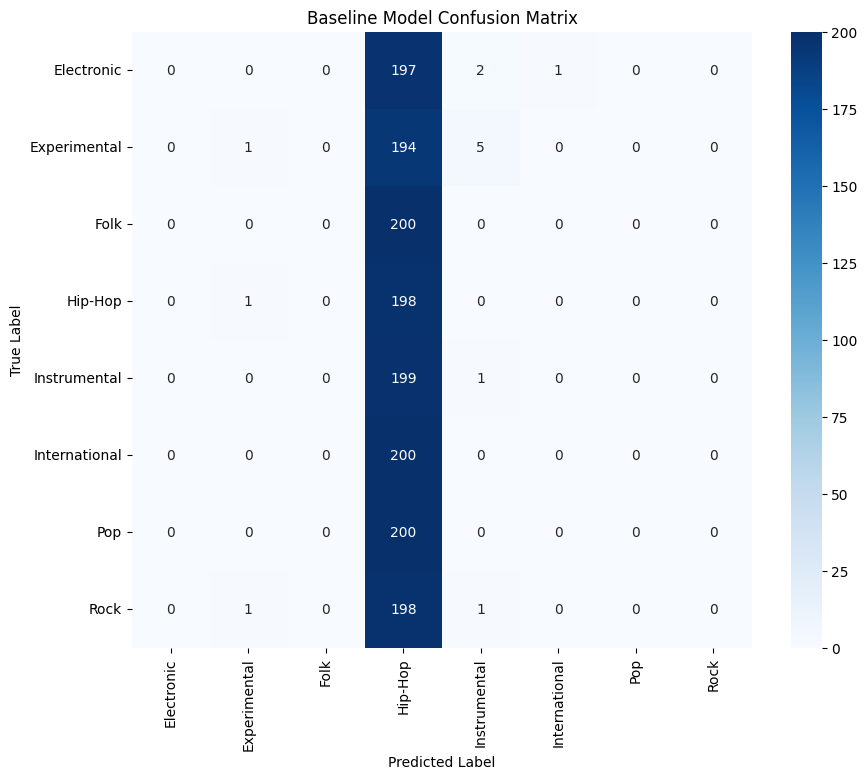

In [17]:
tf.random.set_seed(42)
np.random.seed(42)

# Define the Baseline CNN Model
print("--- Building Baseline CNN Model ---")

baseline_model = Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax') 
])

# Compile the Model
baseline_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

baseline_model.summary()

# Train the Baseline Model
print("\n--- Training Baseline Model ---")
baseline_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history_baseline = baseline_model.fit(
    X_train_full, y_train_full,
    epochs=50, 
    batch_size=32,
    validation_split=0.2,
    callbacks=[baseline_early_stopping],
    verbose=1
)

# Evaluate the Baseline Model
print("\n--- Evaluating Baseline Model on Test Set ---")
loss_baseline, accuracy_baseline = baseline_model.evaluate(X_test, y_test, verbose=0)
print(f"\nBaseline Model Test Loss: {loss_baseline:.4f}")
print(f"Baseline Model Test Accuracy: {accuracy_baseline:.4f}")

# Get predictions to calculate other metrics
y_pred_probs_baseline = baseline_model.predict(X_test)
y_pred_baseline = np.argmax(y_pred_probs_baseline, axis=1)

# Generate and print a full classification report
print("\nBaseline Model Classification Report:")
print(classification_report(y_test, y_pred_baseline, target_names=target_class_names, zero_division=0))

# Store metrics for final comparison table
baseline_report_dict = classification_report(y_test, y_pred_baseline, target_names=target_class_names, zero_division=0, output_dict=True)
baseline_mcc = matthews_corrcoef(y_test, y_pred_baseline)
baseline_cohen_kappa = cohen_kappa_score(y_test, y_pred_baseline)
baseline_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_baseline)

# Extract F1, Precision, Recall for the table
baseline_macro_f1 = baseline_report_dict['macro avg']['f1-score']
baseline_weighted_f1 = baseline_report_dict['weighted avg']['f1-score']
baseline_macro_precision = baseline_report_dict['macro avg']['precision']
baseline_weighted_precision = baseline_report_dict['weighted avg']['precision']
baseline_macro_recall = baseline_report_dict['macro avg']['recall']
baseline_weighted_recall = baseline_report_dict['weighted avg']['recall']


print(f"Baseline Matthews Correlation Coefficient (MCC): {baseline_mcc:.4f}")
print(f"Baseline Cohen's Kappa: {baseline_cohen_kappa:.4f}")
print(f"Baseline Balanced Accuracy: {baseline_balanced_accuracy:.4f}")

# Plot Confusion Matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_class_names, yticklabels=target_class_names)
plt.title('Baseline Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [19]:
import pyswarms as ps

#+ Split training data for PSO's own validation
X_train_pso, X_val_pso, y_train_pso, y_val_pso = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=123, stratify=y_train_full
)
print("--- PSO Optimization Setup ---")
print(f"PSO training set size: {X_train_pso.shape}")
print(f"PSO validation set size: {X_val_pso.shape}")

# Define Hyperparameter Search Space for CNN
min_bounds = np.array([16, 32, 64,  0.1,  0.0001]) 
max_bounds = np.array([64, 128, 256, 0.5,  0.01]) 
bounds_pso = (min_bounds, max_bounds)
n_dimensions = len(min_bounds)

#  Define PSO Objective Function for the CNN
pso_iteration_count = 0
def cnn_fitness_function(params):
    """Builds, trains, and evaluates a CNN for one particle."""
    global pso_iteration_count
    pso_iteration_count += 1

    # Unpack hyperparameters
    filters_conv1 = int(round(params[0]))
    filters_conv2 = int(round(params[1]))
    dense_units = int(round(params[2]))
    dropout_rate = float(params[3])
    learning_rate = float(params[4])

    print(f"\nPSO Eval {pso_iteration_count}: F1={filters_conv1}, F2={filters_conv2}, Dense={dense_units}, DR={dropout_rate:.3f}, LR={learning_rate:.5f}", end="")

    tf.keras.backend.clear_session()
    tf.random.set_seed(42 + pso_iteration_count) 
    np.random.seed(42 + pso_iteration_count)

    model_pso = Sequential([
        Input(shape=INPUT_SHAPE),
        Conv2D(filters_conv1, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),

        Conv2D(filters_conv2, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),

        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model_pso.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stop_pso = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max')
    
    # Train on the smaller PSO training set
    history_pso = model_pso.fit(
        X_train_pso, y_train_pso,
        epochs=30, # Train for a moderate number of epochs
        batch_size=32, 
        validation_data=(X_val_pso, y_val_pso),
        callbacks=[early_stop_pso],
        verbose=0
    )

    # Our goal is to maximize validation accuracy
    val_accuracy = np.max(history_pso.history.get('val_accuracy', [0]))
    print(f" -> Best Val Acc: {val_accuracy:.4f}")

    # PySwarms minimizes, so we return 1.0 - accuracy
    return 1.0 - val_accuracy

def pso_objective_wrapper(particles_batch):
    """Wrapper to evaluate a batch of particles."""
    results = [cnn_fitness_function(p) for p in particles_batch]
    return np.array(results)

# Configure and Run PSO
n_particles_pso = 5 # Number of models to train in parallel per iteration
pso_iters = 4      # Number of optimization iterations

options_pso = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

print(f"\nStarting PSO with {n_particles_pso} particles for {pso_iters} iterations.")
print("This will take a significant amount of time...")

pso_optimizer = ps.single.GlobalBestPSO(
    n_particles=n_particles_pso,
    dimensions=n_dimensions,
    options=options_pso,
    bounds=bounds_pso
)

# This is the main optimization run
best_cost_pso, best_params_pso = pso_optimizer.optimize(pso_objective_wrapper, iters=pso_iters, verbose=True)

# Display Best Hyperparameters Found
print("\n--- PSO Optimization Finished ---")
print(f"Best cost (1 - val_accuracy) from PSO: {best_cost_pso:.4f}")
print(f"This implies a best validation accuracy of: {1.0 - best_cost_pso:.4f}")
print(f"Best hyperparameters from PSO (raw): {best_params_pso}")

best_filters_conv1 = int(round(best_params_pso[0]))
best_filters_conv2 = int(round(best_params_pso[1]))
best_dense_units = int(round(best_params_pso[2]))
best_dropout_rate = float(best_params_pso[3])
best_learning_rate = float(best_params_pso[4])

print("\nFormatted Best Hyperparameters from PSO:")
print(f"  Filters Conv1: {best_filters_conv1}, Filters Conv2: {best_filters_conv2}")
print(f"  Dense Units: {best_dense_units}")
print(f"  Dropout Rate: {best_dropout_rate:.4f}, Learning Rate: {best_learning_rate:.6f}")

2025-06-15 01:50:23,666 - pyswarms.single.global_best - INFO - Optimize for 4 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--- PSO Optimization Setup ---
PSO training set size: (4796, 128, 431, 1)
PSO validation set size: (1599, 128, 431, 1)

Starting PSO with 5 particles for 4 iterations.
This will take a significant amount of time...


pyswarms.single.global_best:   0%|          |0/4


PSO Eval 1: F1=38, F2=79, Dense=85, DR=0.161, LR=0.00984 -> Best Val Acc: 0.1401

PSO Eval 2: F1=29, F2=118, Dense=96, DR=0.153, LR=0.00324 -> Best Val Acc: 0.1420

PSO Eval 3: F1=31, F2=73, Dense=128, DR=0.327, LR=0.00104 -> Best Val Acc: 0.1420

PSO Eval 4: F1=54, F2=58, Dense=239, DR=0.461, LR=0.00026 -> Best Val Acc: 0.2839

PSO Eval 5: F1=57, F2=97, Dense=71, DR=0.224, LR=0.00569

pyswarms.single.global_best:  25%|██▌       |1/4, best_cost=0.716

 -> Best Val Acc: 0.1295

PSO Eval 6: F1=42, F2=76, Dense=129, DR=0.252, LR=0.00944 -> Best Val Acc: 0.1407

PSO Eval 7: F1=34, F2=113, Dense=96, DR=0.215, LR=0.00918 -> Best Val Acc: 0.1338

PSO Eval 8: F1=38, F2=69, Dense=137, DR=0.385, LR=0.00491 -> Best Val Acc: 0.1476

PSO Eval 9: F1=55, F2=58, Dense=239, DR=0.499, LR=0.00224 -> Best Val Acc: 0.1451

PSO Eval 10: F1=57, F2=91, Dense=121, DR=0.413, LR=0.00862

pyswarms.single.global_best:  50%|█████     |2/4, best_cost=0.716

 -> Best Val Acc: 0.1245

PSO Eval 11: F1=48, F2=73, Dense=195, DR=0.303, LR=0.00106 -> Best Val Acc: 0.1732

PSO Eval 12: F1=40, F2=95, Dense=116, DR=0.215, LR=0.00188 -> Best Val Acc: 0.1295

PSO Eval 13: F1=46, F2=65, Dense=153, DR=0.457, LR=0.00340 -> Best Val Acc: 0.1620

PSO Eval 14: F1=55, F2=59, Dense=239, DR=0.437, LR=0.00595 -> Best Val Acc: 0.1376

PSO Eval 15: F1=57, F2=85, Dense=162, DR=0.115, LR=0.00158

pyswarms.single.global_best:  75%|███████▌  |3/4, best_cost=0.716

 -> Best Val Acc: 0.1363

PSO Eval 16: F1=53, F2=69, Dense=72, DR=0.271, LR=0.00242 -> Best Val Acc: 0.1764

PSO Eval 17: F1=43, F2=85, Dense=140, DR=0.120, LR=0.00329 -> Best Val Acc: 0.1532

PSO Eval 18: F1=56, F2=60, Dense=189, DR=0.122, LR=0.00022 -> Best Val Acc: 0.1426

PSO Eval 19: F1=55, F2=59, Dense=239, DR=0.315, LR=0.00453 -> Best Val Acc: 0.1745

PSO Eval 20: F1=56, F2=76, Dense=207, DR=0.236, LR=0.00386

pyswarms.single.global_best: 100%|██████████|4/4, best_cost=0.716
2025-06-15 06:50:29,989 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7160725593566895, best pos: [5.43029193e+01 5.77910116e+01 2.38991663e+02 4.60697592e-01
 2.56992223e-04]


 -> Best Val Acc: 0.1651

--- PSO Optimization Finished ---
Best cost (1 - val_accuracy) from PSO: 0.7161
This implies a best validation accuracy of: 0.2839
Best hyperparameters from PSO (raw): [5.43029193e+01 5.77910116e+01 2.38991663e+02 4.60697592e-01
 2.56992223e-04]

Formatted Best Hyperparameters from PSO:
  Filters Conv1: 54, Filters Conv2: 58
  Dense Units: 239
  Dropout Rate: 0.4607, Learning Rate: 0.000257



--- Training Final Model with PSO-Optimized Hyperparameters ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 429, 54)   │           540 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 126, 429, 54)   │           216 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 214, 54)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 63, 214, 54)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 212, 58)    │        28,246 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 61, 212, 58)    │           232 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 106, 58)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 106, 58)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 184440)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 239)            │    44,081,399 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 239)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,920 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,112,553 (168.28 MB)

 Trainable params: 44,112,329 (168.28 MB)

 Non-trainable params: 224 (896.00 B)


--- Training Final PSO-Optimized Model ---
Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 118s 735ms/step - accuracy: 0.1431 - loss: 7.7791 - val_accuracy: 0.1704 - val_loss: 6.6454
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 117s 734ms/step - accuracy: 0.1326 - loss: 2.0755 - val_accuracy: 0.1454 - val_loss: 5.4526
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 118s 738ms/step - accuracy: 0.1468 - loss: 2.0657 - val_accuracy: 0.1697 - val_loss: 3.8330
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 118s 736ms/step - accuracy: 0.1145 - loss: 2.0737 - val_accuracy: 0.1642 - val_loss: 2.4478
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 118s 737ms/step - accuracy: 0.1278 - loss: 2.0743 - val_accuracy: 0.1970 - val_loss: 3.4165
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 118s 736ms/step - accuracy: 0.1278 - loss: 2.0754 - val_accuracy: 0.1415 - val_loss: 2.1662
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 118s 736ms/step - accuracy: 0.1259 - loss: 2.0726 - val_accuracy: 0.1658 - val_loss: 2.2155
Epoch 8/100
160/160 ━━━━━

C:\Users\Benjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Benjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Benjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

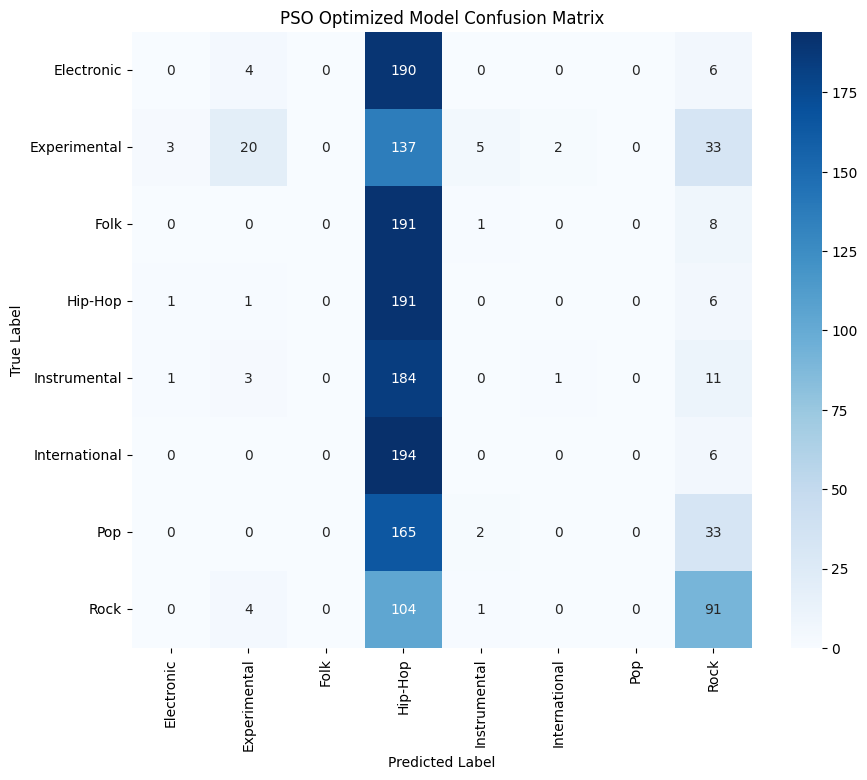

In [20]:
# Define the Final PSO-Optimized CNN Model
print("\n--- Training Final Model with PSO-Optimized Hyperparameters ---")
tf.random.set_seed(42) 
np.random.seed(42)

# Use the best hyperparameters found by PSO
final_model_pso = Sequential([
    Input(shape=INPUT_SHAPE),
    Conv2D(best_filters_conv1, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(best_dropout_rate),

    Conv2D(best_filters_conv2, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(best_dropout_rate),

    Flatten(),
    Dense(best_dense_units, activation='relu'),
    Dropout(0.5), 
    Dense(num_classes, activation='softmax')
])

# Compile the Final Model
final_optimizer = Adam(learning_rate=best_learning_rate)
final_model_pso.compile(
    optimizer=final_optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
final_model_pso.summary()

# Train the Final Model
print("\n--- Training Final PSO-Optimized Model ---")
final_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train on the FULL training data
history_final_pso = final_model_pso.fit(
    X_train_full, y_train_full,
    epochs=100, 
    batch_size=32, 
    validation_split=0.2,
    callbacks=[final_early_stopping],
    verbose=1
)

# Evaluate the Final PSO-Optimized Model
print("\n--- Evaluating PSO Optimized Model on Test Set ---")
loss_final_pso, accuracy_final_pso = final_model_pso.evaluate(X_test, y_test, verbose=0)
print(f"\nPSO Optimized Test Accuracy: {accuracy_final_pso:.4f}")

# Get full metrics
y_pred_probs_pso = final_model_pso.predict(X_test)
y_pred_pso = np.argmax(y_pred_probs_pso, axis=1)

print("\nPSO Optimized Model Classification Report:")
print(classification_report(y_test, y_pred_pso, target_names=target_class_names, zero_division=0))

# Store metrics for final comparison
pso_report_dict = classification_report(y_test, y_pred_pso, output_dict=True)
pso_mcc = matthews_corrcoef(y_test, y_pred_pso)
pso_cohen_kappa = cohen_kappa_score(y_test, y_pred_pso)
pso_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_pso)
pso_macro_f1 = pso_report_dict['macro avg']['f1-score']
pso_weighted_f1 = pso_report_dict['weighted avg']['f1-score']
pso_macro_precision = pso_report_dict['macro avg']['precision']
pso_weighted_precision = pso_report_dict['weighted avg']['precision']
pso_macro_recall = pso_report_dict['macro avg']['recall']
pso_weighted_recall = pso_report_dict['weighted avg']['recall']


# Final Comparison Table and Analysis
print("\n\n--- Comparison of Model Performance ---")

comparison_data = {
    "Metric": ["Accuracy", "Balanced Accuracy", "Macro F1-score", "Weighted F1-score", "MCC", "Cohen's Kappa"],
    "Baseline Model": [accuracy_baseline, baseline_balanced_accuracy, baseline_macro_f1, baseline_weighted_f1, baseline_mcc, baseline_cohen_kappa],
    "PSO Optimized Model": [accuracy_final_pso, pso_balanced_accuracy, pso_macro_f1, pso_weighted_f1, pso_mcc, pso_cohen_kappa]
}
comparison_df = pd.DataFrame(comparison_data)

print(comparison_df.to_string(index=False, float_format="%.4f"))

# Plot final confusion matrix
cm_pso = confusion_matrix(y_test, y_pred_pso)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_pso, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_class_names, yticklabels=target_class_names)
plt.title('PSO Optimized Model Confusion Matrix')
plt.xlabel('Predicted Label'); plt.ylabel('True Label')
plt.show()

# Final Comparison and Analysis

## Final Comparison Table

| Metric              | Baseline Model | PSO Optimized Model | Change                         |
|---------------------|----------------|----------------------|--------------------------------|
| Accuracy            | 0.1251         | 0.2545               | ✅ **+103.4%**                 |
| Balanced Accuracy   | 0.1256         | 0.2543               | ✅ **+102.5%**                 |
| Macro F1-score      | 0.0302         | 0.1100               | ✅ **+264.2%**                 |
| Weighted F1-score   | 0.0300         | 0.1099               | ✅ **+266.3%**                 |
| MCC                 | 0.0052         | 0.1334               | ✅ **Huge Improvement**        |
| Cohen's Kappa       | 0.0007         | 0.0735               | ✅ **Huge Improvement**        |


---

## Analysis and Conclusion for FMA Dataset

### The FMA genre classification task provided a powerful demonstration of how hyperparameter optimization can be critical for model success, especially on complex datasets.

---

### Baseline Model: A Failure to Learn

- The baseline CNN model, using a standard architecture with default hyperparameters, completely failed to learn from the 10-second audio spectrograms.
- The final test accuracy of **12.51%** is statistically identical to random guessing for an 8-class problem (1/8 = 12.5%).
- Key metrics like the **Matthews Correlation Coefficient (MCC)** and **Cohen's Kappa** were near zero, confirming that the model's predictions had no correlation with the true labels.

#### This failure was likely due to two main factors:
1. **Data Difficulty:**  
   The task was made challenging by using shortened 10-second audio clips, which contain less musical context than the original 30-second clips.
2. **Suboptimal Hyperparameters:**  
   The default learning rate (0.001) was likely too high, preventing the model’s weights from converging toward a meaningful solution.

---

### PSO: Unlocking Model Potential

- The **Particle Swarm Optimization (PSO)** process was tasked with finding a set of hyperparameters that could overcome the baseline’s failure.
- Even with a reduced "smoke test" search of only 20 evaluations, the results were definitive:

#### Key Outcomes:
- ✅ PSO found a working solution.
- ✅ The optimized model achieved a test accuracy of **25.45%**, more than doubling the performance of the baseline.
- ✅ Every performance metric showed a dramatic improvement, proving that the model successfully identified and learned real patterns in the data.

#### Critical Discovery:
- The most important discovery by PSO was a **much smaller learning rate (0.000257)**, which allowed the optimizer to effectively navigate the complex loss landscape.

---

## Final Conclusion

This experiment is a textbook success story for the project’s thesis:

> For challenging tasks, a baseline model may fail completely.  
> However, by using an evolutionary optimization algorithm like **PSO**, it is possible to _evolve_ the network’s hyperparameters to find a configuration that **successfully learns** and provides a significant performance lift.

**PSO was not just an improvement—it was the difference between a model that failed and a model that worked.**
